# FiftyOne

In [71]:
from google.colab import drive

#you will have to change this for your own folder
drive.mount('/content/drive')
%cd /content/drive/My Drive/MACHINE LEARNING - Masters/project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MACHINE LEARNING - Masters/project


In [72]:
!pip3 install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import fiftyone as fo
import fiftyone.zoo as foz

In [74]:
dataset = foz.load_zoo_dataset(
              "open-images-v6",
              split="validation",
              label_types=["detections"],
              classes=["Person", "Car", "Street"],
              max_samples=1000,
          )

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


Ignoring invalid classes ['Street']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`


You can view the available classes via `fiftyone.utils.openimages.get_classes()`


Found 500 images, downloading the remaining 500


INFO:fiftyone.utils.openimages:Found 500 images, downloading the remaining 500


 100% |███████████████████| 500/500 [2.4m elapsed, 0s remaining, 2.7 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 500/500 [2.4m elapsed, 0s remaining, 2.7 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


Ignoring invalid classes ['Street']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`


You can view the available classes via `fiftyone.utils.openimages.get_classes()`


 100% |███████████████| 1000/1000 [17.7s elapsed, 0s remaining, 55.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 1000/1000 [17.7s elapsed, 0s remaining, 55.9 samples/s]      


Dataset 'open-images-v6-validation-1000' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation-1000' created


In [75]:
# Writing image path & label to list of dicts
dict_list = []
for item in dataset:
  label_dict = {}
  label_list = []
  for detection in item.detections.detections:
    label = detection.label
    label = label.replace(' ', '_')
    if label not in label_list:
      label_list.append(label)
  label_dict['image_id'] = item.filepath
  label_dict['labels'] = ' '.join(label_list)
  dict_list.append(label_dict)

In [ ]:
# Process dict list to remove very rare labels
#for dictionary in dict_list:
#  dictionary.values

In [77]:
# Writing image path & label to csv
import csv

field_names = ['image_id', 'labels']
csv_file = "fiftyone_1000.csv"
with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = field_names)
    writer.writeheader()
    writer.writerows(dict_list)

# Processing

In [53]:
import pandas as pd
from fastai.vision.all import *

In [100]:
repl_count = 5

train_df = pd.read_csv('data_modified.csv')
train_df = pd.concat([train_df]*repl_count, ignore_index=True)

train_db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=EndSplitter(valid_pct=0.2),
                    get_x=ColReader(0),
                    get_y=ColReader(1, label_delim=' '),
                    item_tfms=Resize(600, 'pad', 'border'), # 224
                    batch_tfms=aug_transforms(mult=1.0, pad_mode='border', p_affine=1.0, p_lighting=1.0))
print(train_db)
print(train_df)
dls = train_db.dataloaders(train_df, bs=16)

                                                                image_id  \
0     /root/fiftyone/open-images-v6/validation/data/001a809ad40a2f84.jpg   
1     /root/fiftyone/open-images-v6/validation/data/00723dac8201a83e.jpg   
2     /root/fiftyone/open-images-v6/validation/data/017b690dbb7552db.jpg   
3     /root/fiftyone/open-images-v6/validation/data/0197df7725980004.jpg   
4     /root/fiftyone/open-images-v6/validation/data/01f8886b50a031a1.jpg   
...                                                                  ...   
4995  /root/fiftyone/open-images-v6/validation/data/049b2fae5ca8aa8b.jpg   
4996  /root/fiftyone/open-images-v6/validation/data/049cbdf58c353959.jpg   
4997  /root/fiftyone/open-images-v6/validation/data/049e7e84b7055f7f.jpg   
4998  /root/fiftyone/open-images-v6/validation/data/049f8c318731eb54.jpg   
4999  /root/fiftyone/open-images-v6/validation/data/04a27da7e880ddcd.jpg   

                                                                                       

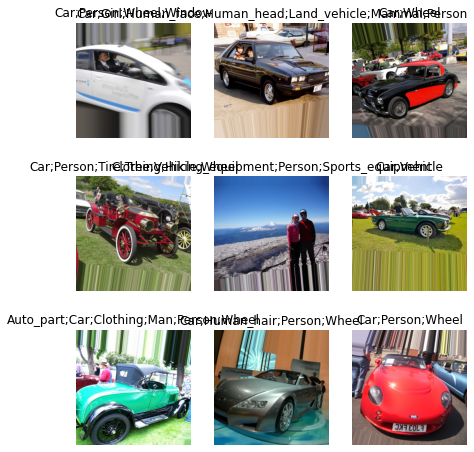

In [101]:
dls.show_batch(max_n=9, figsize=(7,8))

# FastAI 

In [56]:
!pip install fastai==2.7.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): return x + self.conv2(self.conv1(x))

In [81]:
def conv2(ni, nf): return ConvLayer(ni, nf, stride=2)

def conv_and_res(ni, nf): return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [82]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs) # loads standard model
    m.avgpool = nn.AdaptiveAvgPool2d(output_size=(200,200)) # changes one layer
    m.add_module('convres_1', conv_and_res(1,8))
    m.add_module('convres_2', conv_and_res(8,16))
    m.add_module('convres_3', conv_and_res(16,32))
    m.add_module('convres_4', conv_and_res(32,16))
    m.add_module('convres_5', conv_and_res(64,32))
    return m

In [83]:
class SAM(Callback):
    "Sharpness-Aware Minimization"
    def __init__(self, zero_grad=True, rho=0.05, eps=1e-12, **kwargs): 
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        self.state = defaultdict(dict)
        store_attr()

    def params(self): return self.learn.opt.all_params(with_grad=True)
    def _grad_norm(self): return torch.norm(torch.stack([p.grad.norm(p=2) for p,*_ in self.params()]), p=2)
    
    @torch.no_grad()
    def first_step(self):
        scale = self.rho / (self._grad_norm() + self.eps)
        for p,*_ in self.params():
            self.state[p]["e_w"] = e_w = p.grad * scale
            p.add_(e_w)  # climb to the local maximum "w + e(w)"
        if self.zero_grad: self.learn.opt.zero_grad()
        
    @torch.no_grad()    
    def second_step(self):
        for p,*_ in self.params(): p.sub_(self.state[p]["e_w"])

    def before_step(self, **kwargs):
        self.first_step()
        self.learn.pred = self.model(*self.xb); self.learn('after_pred')
        self.loss_func(self.learn.pred, *self.yb).backward()
        self.second_step()

In [105]:
learn = vision_learner(dls, partial(get_model, model=resnet34), metrics=partial(accuracy_multi, thresh=0.1), loss_func=BCEWithLogitsLossFlat())

In [106]:
learn.fit_one_cycle(10, cbs=[SAM()])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.972274,0.730532,0.057965,03:53
1,0.267580,0.094232,0.904176,03:51
2,0.081084,0.057416,0.960789,03:52
3,0.066449,0.045555,0.964162,03:53
4,0.055787,0.037162,0.967317,03:51
5,0.050707,0.032808,0.969916,03:51
6,0.045089,0.028934,0.974465,03:55
7,0.042856,0.026437,0.975078,03:53
8,0.041033,0.025584,0.976753,03:58
9,0.040026,0.025616,0.975310,03:54


# Classification

In [107]:
labels_df = pd.read_csv('data/labels.csv')
test_df = pd.read_csv('data/test.csv')
img_series = test_df.sample().iloc[0]
img_path = 'data/images/' + img_series['image_id']
img = load_image(img_path)
print(img_series)

image_id    img176.jpg
Name: 22, dtype: object


In [108]:
pred_class,pred_idx,outputs = learn.predict(img_path)

[Empty DataFrame
 Columns: [label_id, object]
 Index: [], Empty DataFrame
 Columns: [label_id, object]
 Index: [], Empty DataFrame
 Columns: [label_id, object]
 Index: [], Empty DataFrame
 Columns: [label_id, object]
 Index: [], Empty DataFrame
 Columns: [label_id, object]
 Index: []]

In [109]:
from os import listdir

In [110]:
file_names = listdir('data/images')
for i in test_df.index:
  if test_df.at[i, 'image_id'] in file_names:
    img_path = 'data/images/' + test_df.at[i, 'image_id']
    print(img_path)
    pred_class,pred_idx,outputs = learn.predict(img_path)
    print(pred_class)
    test_df.at[i, 'labels'] = ' '.join(pred_class)
  else:
    test_df.at[i, 'labels'] = ''
print(test_df)

data/images/img102.jpg


['Car', 'Clothing', 'Girl', 'Human_body', 'Human_hair', 'Mammal', 'Man', 'Person', 'Woman']
data/images/img103.jpg


['Person', 'Plant', 'Tree']
data/images/img11.jpg


['Footwear', 'Mammal', 'Person']
data/images/img113.jpg


['Person', 'Tree']
data/images/img114.jpg


['Plant', 'Tree']
data/images/img121.jpg


['Person', 'Plant', 'Tree']
data/images/img126.jpg


['Clothing', 'Footwear', 'Mammal', 'Person']
data/images/img131.jpg


['Car', 'Clothing', 'Girl', 'Human_arm', 'Human_body', 'Human_eye', 'Human_hair', 'Human_mouth', 'Mammal', 'Person', 'Woman']
data/images/img136.jpg


['Clothing', 'Human_arm', 'Human_body', 'Human_hair', 'Human_hand', 'Mammal', 'Person']
data/images/img137.jpg


['Mammal', 'Plant', 'Tree']
data/images/img139.jpg


['Car', 'Person', 'Plant', 'Tree']
data/images/img140.jpg


['Person']
data/images/img15.jpg


['Car', 'Person']
data/images/img150.jpg


['Car', 'Person', 'Wheel']
data/images/img151.jpg


['Building', 'Car', 'Land_vehicle', 'Person']
data/images/img152.jpg


['Car', 'Land_vehicle', 'Person']
data/images/img156.jpg


['Car', 'Land_vehicle', 'Mammal', 'Person', 'Plant', 'Tree']
data/images/img161.jpg


['Plant', 'Tree']
data/images/img166.jpg


['Car', 'Person', 'Tree']
data/images/img167.jpg


['Car', 'Person']
data/images/img170.jpg


['Car', 'Clothing', 'Footwear', 'Person']
data/images/img173.jpg


['Clothing', 'Footwear', 'Mammal', 'Person', 'Tree']
data/images/img176.jpg


['Clothing', 'Footwear', 'Mammal', 'Man', 'Person']
data/images/img18.jpg


['Car', 'Land_vehicle', 'Plant', 'Tree']
data/images/img180.jpg


['Person', 'Tree']
data/images/img181.jpg


['Person', 'Plant', 'Tree']
data/images/img182.jpg


['Car', 'Clothing', 'Footwear', 'Person', 'Plant', 'Tree']
data/images/img183.jpg


['Car', 'Person', 'Plant', 'Tree']
data/images/img189.jpg


['Person', 'Plant', 'Tree']
data/images/img192.jpg


['Car', 'Land_vehicle', 'Mammal', 'Motorcycle', 'Person', 'Tree', 'Wheel']
data/images/img194.jpg


['Car', 'Land_vehicle', 'Mammal', 'Person', 'Tree']
data/images/img195.jpg


['Clothing', 'Mammal', 'Person']
data/images/img206.jpg


['Land_vehicle', 'Mammal', 'Person', 'Plant', 'Tree']
data/images/img208.jpg


['Plant', 'Tree']
data/images/img209.jpg


['Land_vehicle', 'Person', 'Plant', 'Tree']
data/images/img211.jpg


['Person', 'Plant', 'Tree']
data/images/img212.jpg


['Car', 'Person', 'Plant', 'Tree']
data/images/img218.jpg


['Car', 'Clothing', 'Footwear', 'Mammal', 'Man', 'Person']
data/images/img22.jpg


['Mammal', 'Plant', 'Tree']
data/images/img221.jpg


['Person']
data/images/img228.jpg


['Car', 'Land_vehicle', 'Mammal', 'Person', 'Vehicle']
data/images/img230.jpg


['Car', 'Land_vehicle', 'Mammal', 'Person', 'Tire', 'Tree', 'Wheel']
data/images/img231.jpg


['Car', 'Person', 'Tire']
data/images/img234.jpg


['Car', 'Land_vehicle', 'Person', 'Tree']
data/images/img238.jpg


['Bicycle', 'Bicycle_wheel', 'Car', 'Clothing', 'Footwear', 'Land_vehicle', 'Mammal', 'Person', 'Wheel']
data/images/img243.jpg


['Clothing', 'Mammal', 'Person', 'Plant', 'Tree', 'Woman']
data/images/img247.jpg


['Person', 'Plant', 'Tree']
data/images/img248.jpg


['Car', 'Person', 'Tree']
data/images/img249.jpg


['Person']
data/images/img250.jpg


['Car', 'Person']
data/images/img251.jpg


['Car', 'Person', 'Wheel']
data/images/img252.jpg


['Car', 'Person']
data/images/img257.jpg


['Person']
data/images/img259.jpg


['Clothing', 'Human_hair', 'Mammal', 'Man', 'Person', 'Woman']
data/images/img262.jpg


['Clothing', 'Human_body', 'Person']
data/images/img265.jpg


['Car', 'Person']
data/images/img266.jpg


['Car', 'Person']
data/images/img279.jpg


['Building', 'Car', 'Person']
data/images/img280.jpg


['Clothing', 'Person', 'Woman']
data/images/img281.jpg


['Person']
data/images/img292.jpg


['Car', 'Person', 'Tree']
data/images/img296.jpg


['Building', 'Clothing', 'Person']
data/images/img3.jpg


['Building', 'Car', 'Person']
data/images/img300.jpg


['Car', 'Person']
data/images/img33.jpg


['Mammal', 'Person', 'Plant', 'Tree']
data/images/img37.jpg


['Human_body', 'Mammal', 'Person', 'Plant', 'Tree']
data/images/img39.jpg


['Clothing', 'Human_body', 'Mammal', 'Person']
data/images/img41.jpg


['Car', 'Person']
data/images/img42.jpg


['Person', 'Tree']
data/images/img43.jpg


['Person']
data/images/img48.jpg


['Car', 'Land_vehicle', 'Person', 'Vehicle', 'Wheel']
data/images/img49.jpg


['Car', 'Clothing', 'Footwear', 'Mammal', 'Person', 'Tree']
data/images/img5.jpg


['Airplane', 'Car', 'Land_vehicle', 'Person', 'Vehicle']
data/images/img57.jpg


['Car', 'Person']
data/images/img59.jpg


['Car', 'Land_vehicle', 'Person', 'Vehicle']
data/images/img69.jpg


['Car', 'Land_vehicle', 'Person', 'Plant']
data/images/img71.jpg


['Clothing', 'Human_body', 'Human_hair', 'Mammal', 'Person']
data/images/img73.jpg


['Car', 'Clothing', 'Girl', 'Human_body', 'Human_hair', 'Mammal', 'Man', 'Person', 'Woman']
data/images/img75.jpg


['Clothing', 'Person', 'Woman']
data/images/img79.jpg


['Carnivore', 'Clothing', 'Dog', 'Mammal', 'Person', 'Tree']
data/images/img8.jpg


['Car', 'Person']
data/images/img81.jpg


['Clothing', 'Mammal', 'Person', 'Tree']
data/images/img84.jpg


['Clothing', 'Human_body', 'Mammal', 'Person']
data/images/img90.jpg


['Clothing', 'Human_arm', 'Human_body', 'Human_face', 'Human_head', 'Mammal', 'Man', 'Person']
data/images/img93.jpg


['Person']
data/images/img94.jpg


['Person', 'Plant']
      image_id  \
0   img102.jpg   
1   img103.jpg   
2    img11.jpg   
3   img113.jpg   
4   img114.jpg   
..         ...   
83   img81.jpg   
84   img84.jpg   
85   img90.jpg   
86   img93.jpg   
87   img94.jpg   

                                                                   labels  
0         Car Clothing Girl Human_body Human_hair Mammal Man Person Woman  
1                                                       Person Plant Tree  
2                                                  Footwear Mammal Person  
3                                                             Person Tree  
4                                                              Plant Tree  
..                                                                    ...  
83                                            Clothing Mammal Person Tree  
84                                      Clothing Human_body Mammal Person  
85  Clothing Human_arm Human_body Human_face Human_head Mammal Man Person  
86 